# DataJoint U24 - Workflow Calcium Imaging

## Setup

First, let's change directories to find the `dj_local_conf` file.

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='workflow-calcium-imaging', (
    "Please move to the workflow directory")
# We'll be working with long tables, so we'll make visualization easier with a limit
import datajoint as dj; dj.config['display.limit']=10

Next, we populate the python namespace with the required schemas

In [2]:
from workflow_calcium_imaging.pipeline import session, imaging, trial, event

Connecting root@localhost:3306


## Trial and Event schemas

Tables in the `trial` and `event` schemas specify the structure of your experiment, including block, trial and event timing. 
- Session has a 1-to-1 mapping with a behavior recording
- A block is a continuous phase of an experiment that contains repeated instances of a condition, or trials. 
- Events may occur within or outside of conditions, either instantaneous or continuous.

The diagram below shows (a) the levels of hierarchy and (b) how the bounds may not completely overlap. A block may not fully capure trials and events may occur outside both blocks/trials.

```
|----------------------------------------------------------------------------|
|-------------------------------- Session ---------------------------------|__
|-------------------------- BehaviorRecording ---------------------------|____
|----- Block 1 -----|______|----- Block 2 -----|______|----- Block 3 -----|___
| trial 1 || trial 2 |____| trial 3 || trial 4 |____| trial 5 |____| trial 6 |
|_|e1|_|e2||e3|_|e4|__|e5|__|e6||e7||e8||e9||e10||e11|____|e12||e13|_________|
|----------------------------------------------------------------------------|
```

Let's load some example data. The `ingest.py` script has a series of loaders to help. If you've already run the other notebooks, you might skip `ingest_subjects` and `ingest_sessions`.

In [3]:
from workflow_calcium_imaging.ingest import ingest_subjects, ingest_sessions,\
                                            ingest_events, ingest_alignment

In [4]:
# ingest_subjects(); ingest_sessions()
ingest_events()


---- Inserting 0 entry(s) into behavior_recording ----

---- Inserting 0 entry(s) into behavior_recording__file ----

---- Inserting 0 entry(s) into _block ----

---- Inserting 0 entry(s) into _block__attribute ----

---- Inserting 0 entry(s) into #trial_type ----

---- Inserting 0 entry(s) into _trial ----

---- Inserting 0 entry(s) into _trial__attribute ----

---- Inserting 0 entry(s) into _block_trial ----

---- Inserting 0 entry(s) into #event_type ----

---- Inserting 0 entry(s) into _event ----

---- Inserting 52 entry(s) into _trial_event ----


We have 40 total trials, either 'stim' or 'ctrl', with start and stop time

In [5]:
trial.Trial()

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject3,2021-10-25 13:06:40,1,stim,0.285,20.285
subject3,2021-10-25 13:06:40,2,ctrl,23.927,43.927
subject3,2021-10-25 13:06:40,3,stim,47.622,67.622
subject3,2021-10-25 13:06:40,4,ctrl,71.443,91.443
subject3,2021-10-25 13:06:40,5,ctrl,95.385,115.385
subject3,2021-10-25 13:06:40,6,ctrl,119.331,139.331
subject3,2021-10-25 13:06:40,7,ctrl,143.254,163.254
subject3,2021-10-25 13:06:40,8,stim,166.86,186.86
subject3,2021-10-25 13:06:40,9,ctrl,190.465,210.465
subject3,2021-10-25 13:06:40,10,ctrl,214.395,234.395


Each trial is paired with one or more events that take place during the trial window.

In [6]:
trial.TrialEvent() & 'trial_id<5'

subject,session_datetime,trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start
subject3,2021-10-25 13:06:40,1,center,2.794
subject3,2021-10-25 13:06:40,1,center,13.252
subject3,2021-10-25 13:06:40,3,center,59.234
subject3,2021-10-25 13:06:40,4,center,76.33
subject3,2021-10-25 13:06:40,4,center,82.185
subject3,2021-10-25 13:06:40,4,center,89.928
subject3,2021-10-25 13:06:40,1,left,16.014
subject3,2021-10-25 13:06:40,3,left,52.128
subject3,2021-10-25 13:06:40,3,left,65.688


Finally, the `AlignmentEvent` describes the event of interest and the window we'd like to see around it.

In [7]:
ingest_alignment()


---- Inserting 3 entry(s) into alignment_event ----


In [13]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type
center_button,,center,0.0,center,-5.0,center,5.0
left_button,,left,0.0,left,-5.0,left,5.0
right_button,,right,0.0,right,-5.0,right,5.0


# Event-aligned trialized calcium activity

### Analysis

The `analysis` schema provides example tables to perform event-aligned Calcium activity analysis.
+ ***ActivityAlignmentCondition*** - a manual table to specify the inputs and condition for the analysis
+ ***ActivityAlignment*** - a computed table to extract event-aligned Calcium activity (e.g. dF/F, spikes)

Let's start by creating several analyses configuration - i.e. inserting into ***ActivityAlignmentCondition***

In [10]:
imaging.Activity()

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution


We'll isolate the scan of interest with the following key:

In [12]:
ca_activity_key = (imaging.Activity & {'subject': 'subject3', 'scan_id': 0}
                  ).fetch1('KEY')

Here, we can see all trials for this scan:

In [14]:
trial.Trial & ca_activity_key

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject3,2021-10-25 13:06:40,1,stim,0.285,20.285
subject3,2021-10-25 13:06:40,2,ctrl,23.927,43.927
subject3,2021-10-25 13:06:40,3,stim,47.622,67.622
subject3,2021-10-25 13:06:40,4,ctrl,71.443,91.443
subject3,2021-10-25 13:06:40,5,ctrl,95.385,115.385
subject3,2021-10-25 13:06:40,6,ctrl,119.331,139.331
subject3,2021-10-25 13:06:40,7,ctrl,143.254,163.254
subject3,2021-10-25 13:06:40,8,stim,166.86,186.86
subject3,2021-10-25 13:06:40,9,ctrl,190.465,210.465
subject3,2021-10-25 13:06:40,10,ctrl,214.395,234.395


And highlight a subset based on `trial_type`

In [15]:
ctrl_trials = trial.Trial & ca_activity_key & 'trial_type = "ctrl"'
ctrl_trials

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject3,2021-10-25 13:06:40,2,ctrl,23.927,43.927
subject3,2021-10-25 13:06:40,4,ctrl,71.443,91.443
subject3,2021-10-25 13:06:40,5,ctrl,95.385,115.385
subject3,2021-10-25 13:06:40,6,ctrl,119.331,139.331
subject3,2021-10-25 13:06:40,7,ctrl,143.254,163.254
subject3,2021-10-25 13:06:40,9,ctrl,190.465,210.465
subject3,2021-10-25 13:06:40,10,ctrl,214.395,234.395
subject3,2021-10-25 13:06:40,12,ctrl,264.974,284.974
subject3,2021-10-25 13:06:40,15,ctrl,336.724,356.724
subject3,2021-10-25 13:06:40,19,ctrl,431.431,451.431


Here, we target the event of interest with another key:

In [16]:
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"'
                ).fetch1('KEY')
alignment_key

{'alignment_name': 'center_button'}

In [17]:
alignment_condition = {**ca_activity_key, **alignment_key, 
                       'trial_condition': 'ctrl_center_button'}
alignment_condition

{'subject': 'subject3',
 'session_datetime': datetime.datetime(2021, 10, 25, 13, 6, 40),
 'scan_id': 0,
 'paramset_idx': 0,
 'curation_id': 1,
 'extraction_method': 'suite2p_deconvolution',
 'alignment_name': 'center_button',
 'trial_condition': 'ctrl_center_button'}

Next, we add this to the `ActivityAlignment` table in the `analysis` schema

In [18]:
analysis.ActivityAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)

In [19]:
analysis.ActivityAlignmentCondition()

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,condition_description,bin_size bin-size (in second) used to compute the PSTH
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,,0.04


Using the [projection](https://docs.datajoint.org/python/v0.13/queries/08-Proj.html) method, we can generate a table of relevant trials by `trial_type` and `alignment_condition`

In [22]:
sample = (analysis.ActivityAlignmentCondition * ctrl_trials & alignment_condition).proj()
sample

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,2
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,4
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,5
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,6
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,7
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,9
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,10
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,12
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,15
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,19


And insert these trials into the `ActivityAlignmentCondition.Trial` part table

In [23]:
analysis.ActivityAlignmentCondition.Trial.insert(sample, skip_duplicates=True)
analysis.ActivityAlignmentCondition.Trial()

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,2
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,4
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,5
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,6
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,7
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,9
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,10
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,12
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,15
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,19


With the steps above, we have create a new alignment condition for analysis, named `ctrl_center_button`, which specifies:
+ an Activity of interest for analysis
+ an event of interest to align the Ca+ activity to - `center_button`
+ a set of trials of interest to perform the analysis on - `ctrl` trials

---

Now, let's create another set with:
+ the same Activity of interest for analysis
+ an event of interest to align the Ca+ activity to - `center_button`
+ a set of trials of interest to perform the analysis on - `stim` trials

In [24]:
stim_trials = trial.Trial & ca_activity_key & 'trial_type = "stim"'
alignment_condition = {**ca_activity_key, **alignment_key, 
                       'trial_condition': 'stim_center_button'}
analysis.ActivityAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
analysis.ActivityAlignmentCondition.Trial.insert(
    (analysis.ActivityAlignmentCondition * stim_trials & alignment_condition).proj(),
    skip_duplicates=True)

Note the two entries in `ActivityAlignmentCondition.trial_condition`

In [25]:
analysis.ActivityAlignmentCondition()

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,condition_description,bin_size bin-size (in second) used to compute the PSTH
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,,0.04
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,stim_center_button,,0.04


In [19]:
analysis.ActivityAlignmentCondition.Trial & 'trial_condition = "ctrl_center_button"'

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,2
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,4
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,5
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,6
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,7
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,9
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,10
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,12
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,15
subject3,2021-01-28 14:56:52,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,19


### Computation
Just like the element itself, we can run computations with `populate()`

In [4]:
analysis.ActivityAlignment.populate(display_progress=True)

ActivityAlignment: 100%|██████████████████████████| 2/2 [00:50<00:00, 25.29s/it]


In [5]:
analysis.ActivityAlignment()

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,aligned_timestamps
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,stim_center_button,=BLOB=


The `AlignedTrialSpikes` part table captures aligned traces fore each alignment and trial condition specified in the master table.

In [6]:
analysis.ActivityAlignment.AlignedTrialSpikes()

subject,session_datetime,scan_id,paramset_idx,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,mask,fluo_channel 0-based indexing,trial_id trial number (1-based indexing),aligned_trace (s) Calcium activity aligned to the event time
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,4,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,5,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,15,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,19,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,22,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,23,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,33,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,36,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,ctrl_center_button,0,0,40,=BLOB=
subject3,2021-10-25 13:06:40,0,0,1,suite2p_deconvolution,center_button,stim_center_button,0,0,1,=BLOB=


### Visualization

With the `plot_aligned_activities` function, we can see the density of spikes relative to our alignment event.

Connecting cbroz@dss-db.datajoint.io:3306


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 316 and the array at index 4 has size 317

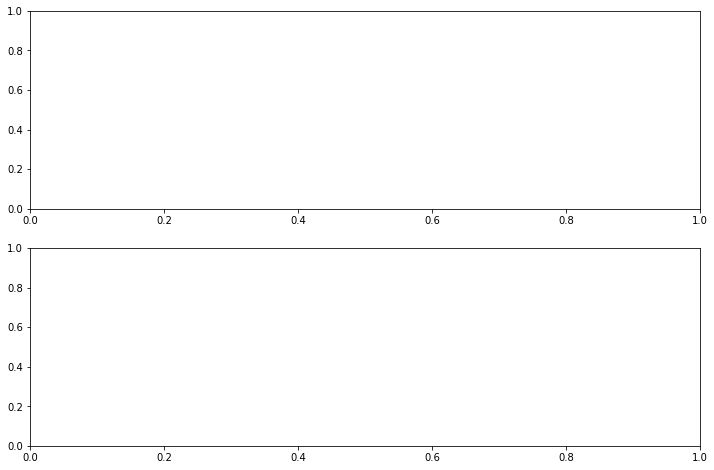

In [2]:
from workflow_calcium_imaging import analysis
from workflow_calcium_imaging.pipeline import session, imaging, trial, event
ca_activity_key = (imaging.Activity & {'subject': 'subject3', 'scan_id': 0}
                  ).fetch1('KEY')
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"'
                ).fetch1('KEY')
alignment_condition = {**ca_activity_key, **alignment_key, 
                       'trial_condition': 'ctrl_center_button'}
analysis.ActivityAlignment().plot_aligned_activities(alignment_condition, roi=2)

In [3]:
%debug

> <__array_function__ internals>(5)concatenate()



ipdb>  u


> /Users/cb/miniconda3/envs/venv-nwb/lib/python3.8/site-packages/numpy/core/shape_base.py(282)vstack()
    280     if not isinstance(arrs, list):
    281         arrs = [arrs]
--> 282     return _nx.concatenate(arrs, 0)
    283 
    284 



ipdb>  u


> <__array_function__ internals>(5)vstack()



ipdb>  


> /Volumes/GoogleDrive/My Drive/NWB/workflow-calcium-imaging/workflow_calcium_imaging/analysis.py(111)plot_aligned_activities()
    109                                                                   order_by='trial_id')
    110 
--> 111         aligned_spikes = np.vstack(aligned_spikes)
    112 
    113         ax0.imgshow(aligned_spikes, cmap='gray', interpolation='nearest')



ipdb>  


> /var/folders/_9/tzvq__ws5z9gv5s7jvkj570r0000gn/T/ipykernel_7502/2914933712.py(9)<module>()
      5 alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"'
      6                 ).fetch1('KEY')
      7 alignment_condition = {**ca_activity_key, **alignment_key, 
      8                        'trial_condition': 'ctrl_center_button'}
----> 9 analysis.ActivityAlignment().plot_aligned_activities(alignment_condition, roi=2)



ipdb>  d


> /Volumes/GoogleDrive/My Drive/NWB/workflow-calcium-imaging/workflow_calcium_imaging/analysis.py(111)plot_aligned_activities()
    109                                                                   order_by='trial_id')
    110 
--> 111         aligned_spikes = np.vstack(aligned_spikes)
    112 
    113         ax0.imgshow(aligned_spikes, cmap='gray', interpolation='nearest')



ipdb>  aligned_spikes.shape()


*** TypeError: 'tuple' object is not callable


ipdb>  aligned_spikes.shape


(9,)


ipdb>  np.vstack(aligned_spikes).shape


*** ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 316 and the array at index 4 has size 317


ipdb>  key


{'subject': 'subject3', 'session_datetime': datetime.datetime(2021, 10, 25, 13, 6, 40), 'scan_id': 0, 'paramset_idx': 0, 'curation_id': 1, 'extraction_method': 'suite2p_deconvolution', 'alignment_name': 'center_button', 'trial_condition': 'ctrl_center_button'}


ipdb>  key = {'subject': 'subject3', 'session_datetime': datetime.datetime(2021, 10, 25, 13, 6, 40), 'scan_id': 0, 'paramset_idx': 0, 'curation_id': 1, 'extraction_method': 'suite2p_deconvolution', 'alignment_name': 'center_button', 'trial_condition': 'ctrl_center_button'}


*** NameError: name 'datetime' is not defined


ipdb>  len(aligned_spikes[0])


316


ipdb>  len(aligned_spikes[1])


316


ipdb>  len(aligned_spikes[8])


290


ipdb>  len(aligned_spikes[7])


317


ipdb>  len(aligned_spikes[6])


317


ipdb>  len(aligned_spikes[5])


317


ipdb>  len(aligned_spikes[4])


317


ipdb>  len(aligned_spikes[3])


316


ipdb>  quit


NameError: name 'aligned_timestamps' is not defined

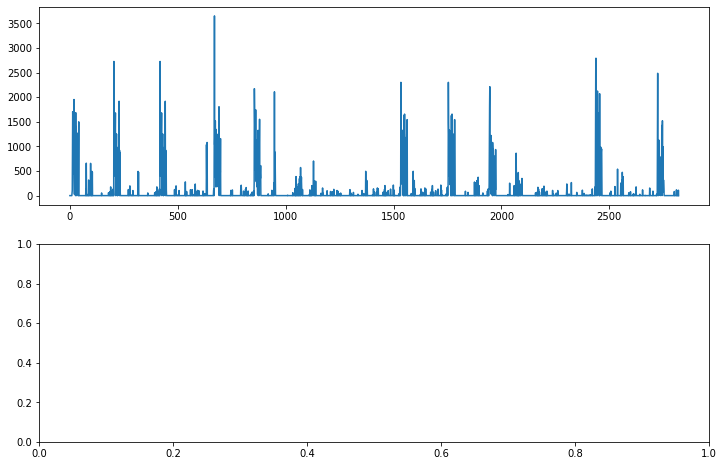

In [43]:
# %debug
import datetime
key = {'subject': 'subject3', 
       'session_datetime': datetime.datetime(2021, 10, 25, 13, 6, 40), 
       'scan_id': 0, 'paramset_idx': 0, 'curation_id': 1, 
       'extraction_method': 'suite2p_deconvolution', 
       'alignment_name': 'center_button', 'trial_condition': 'ctrl_center_button'}
trial_ids, aligned_spikes= (analysis.ActivityAlignment.AlignedTrialSpikes 
                            & key & {'mask': 2}
                           ).fetch('trial_id', 'aligned_trace', order_by='trial_id')
import numpy as np
aligned_spikes = np.vstack(aligned_spikes)
import matplotlib.pyplot as plt
fig = None
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8))
ax0.plot(aligned_spikes)#, cmap='gray', interpolation='nearest')
ax1.plot(aligned_timestamps, np.nanmean(aligned_spikes))

In [41]:
plt

<module 'matplotlib.pyplot' from '/Users/cb/miniconda3/envs/venv-nwb/lib/python3.8/site-packages/matplotlib/pyplot.py'>

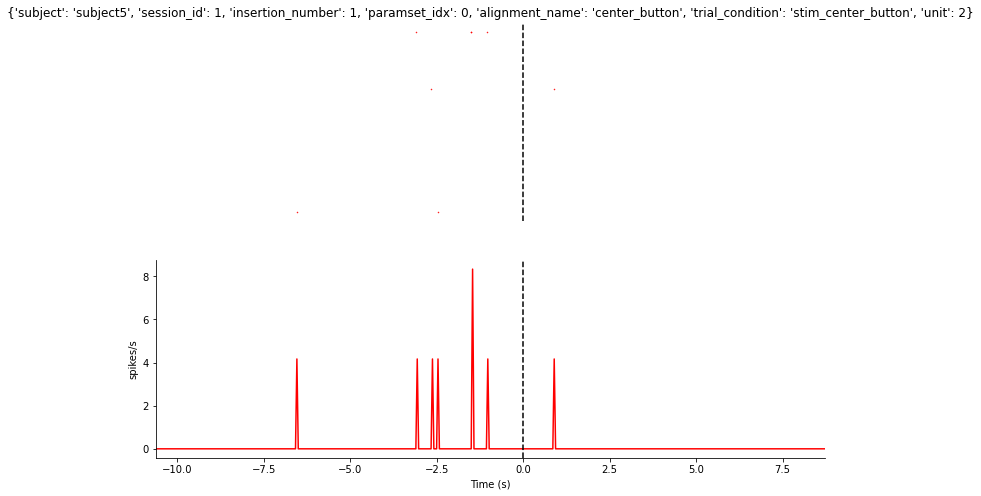

In [6]:
alignment_condition = {**ca_activity_key, **alignment_key, 
                       'trial_condition': 'stim_center_button'}
analysis.ActivityAlignment().plot_aligned_activities(alignment_condition, unit=2);